In [1]:
!pip install -Uqq fastbook

In [2]:
from fastbook import *

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
pd.read_csv('/kaggle/input/paddy-disease-classification/train.csv')

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45
...,...,...,...,...
10402,107607.jpg,tungro,Zonal,55
10403,107811.jpg,tungro,Zonal,55
10404,108547.jpg,tungro,Zonal,55
10405,110245.jpg,tungro,Zonal,55


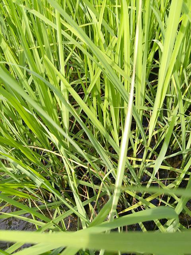

In [4]:
Image.open('/kaggle/input/paddy-disease-classification/train_images/bacterial_leaf_blight/100023.jpg').to_thumb(255)

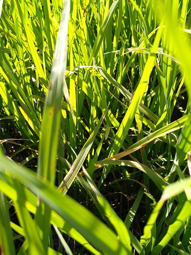

In [5]:
Image.open('/kaggle/input/paddy-disease-classification/train_images/blast/100004.jpg').to_thumb(255)

In [6]:
path = Path('/kaggle/input/paddy-disease-classification')
path

Path('/kaggle/input/paddy-disease-classification')

In [7]:
train_path = path / 'train_images'
train_path

Path('/kaggle/input/paddy-disease-classification/train_images')

In [8]:
train_images = get_image_files(train_path)
len(train_images)

10407

In [9]:
Image.open(train_images[0]).size

(480, 640)

In [10]:
from fastcore.parallel import *

In [11]:
def get_size(item): return Image.open(item).size

sizes = parallel(get_size, train_images, n_workers = 8)
pd.Series(sizes).value_counts()

(480, 640)    10403
(640, 480)        4
dtype: int64

In [12]:
PILImage.create(train_images[0]).size

(480, 640)

In [13]:
path

Path('/kaggle/input/paddy-disease-classification')

In [14]:
train_path

Path('/kaggle/input/paddy-disease-classification/train_images')

In [15]:
set_seed(42)

In [16]:
dls = ImageDataLoaders.from_folder(
    train_path, 
    valid_pct = 0.2, 
    seed = 42, 
    item_tfms = Resize(480, method = 'squish'), 
    batch_transform = aug_transforms(size = 128, min_scale = 0.5)
)

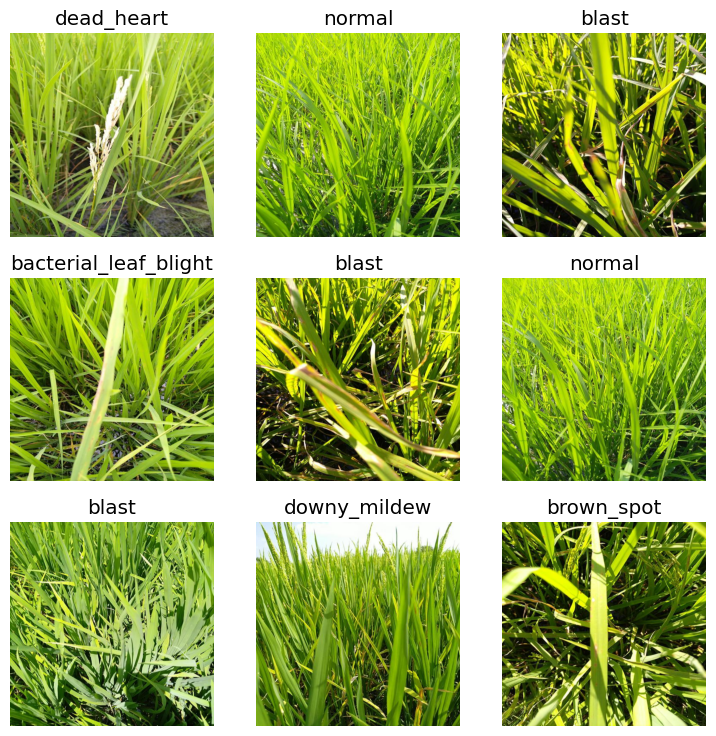

In [17]:
dls.show_batch()

In [18]:
learn = vision_learner(dls, 'resnet26d', metrics = error_rate, path = '.').to_fp16()

SuggestedLRs(valley=0.0014454397605732083, slide=0.001737800776027143)

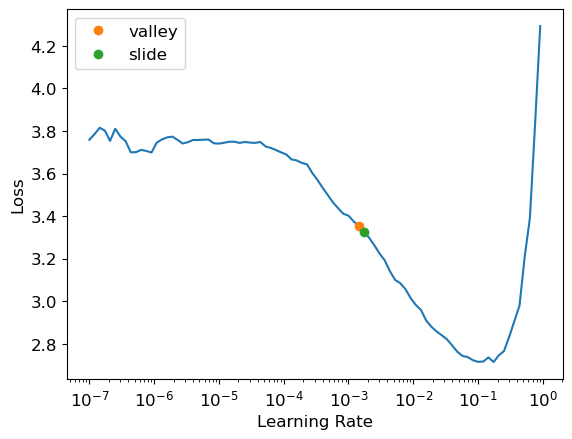

In [19]:
learn.lr_find(suggest_funcs = (valley, slide))

In [20]:
learn.fine_tune(3, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.272052,0.796624,0.246036,01:58


epoch,train_loss,valid_loss,error_rate,time
0,0.661082,0.399673,0.129745,02:19
1,0.254385,0.248458,0.074483,02:17
2,0.075267,0.218419,0.065353,02:18


In [21]:
test_df = pd.read_csv(path/'sample_submission.csv')
test_df.head()

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN


In [22]:
test_images = get_image_files(path/'test_images').sorted()
test_images

(#3469) [Path('/kaggle/input/paddy-disease-classification/test_images/200001.jpg'),Path('/kaggle/input/paddy-disease-classification/test_images/200002.jpg'),Path('/kaggle/input/paddy-disease-classification/test_images/200003.jpg'),Path('/kaggle/input/paddy-disease-classification/test_images/200004.jpg'),Path('/kaggle/input/paddy-disease-classification/test_images/200005.jpg'),Path('/kaggle/input/paddy-disease-classification/test_images/200006.jpg'),Path('/kaggle/input/paddy-disease-classification/test_images/200007.jpg'),Path('/kaggle/input/paddy-disease-classification/test_images/200008.jpg'),Path('/kaggle/input/paddy-disease-classification/test_images/200009.jpg'),Path('/kaggle/input/paddy-disease-classification/test_images/200010.jpg')...]

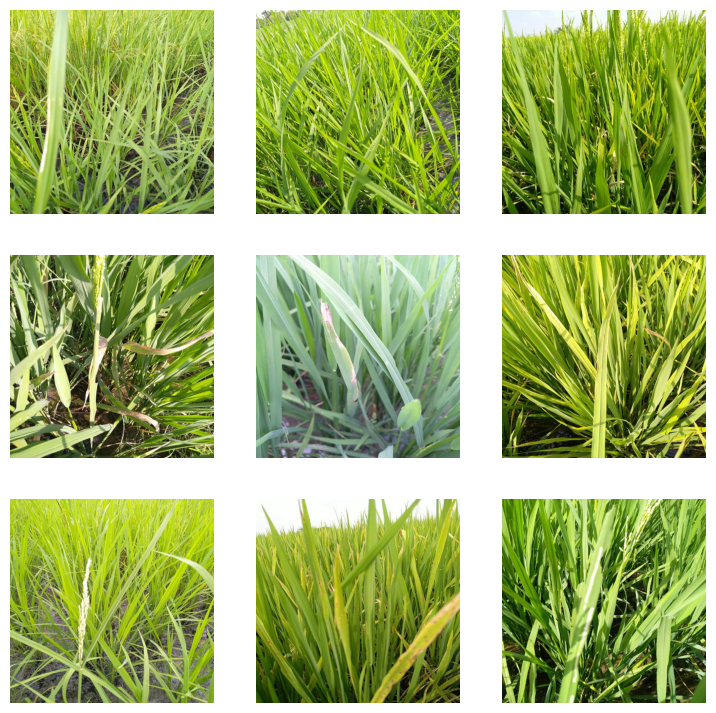

In [23]:
test_dl = learn.dls.test_dl(test_images)
test_dl.show_batch()

In [24]:
test_pred = learn.get_preds(dl = test_dl)

In [25]:
test_pred

(tensor([[5.0797e-07, 1.3349e-10, 1.2279e-07,  ..., 9.8963e-01, 5.4142e-05, 2.8143e-05],
         [4.5033e-06, 1.3978e-06, 1.1725e-06,  ..., 1.0534e-04, 9.9985e-01, 6.7461e-07],
         [3.9115e-05, 4.4590e-04, 2.0943e-03,  ..., 4.4697e-01, 1.7481e-03, 2.7045e-04],
         ...,
         [1.9941e-08, 6.5650e-07, 1.0009e-07,  ..., 1.2554e-07, 9.9998e-01, 1.2176e-06],
         [3.2710e-05, 9.7904e-01, 7.5879e-04,  ..., 1.7761e-04, 2.3014e-05, 1.3205e-04],
         [8.1667e-10, 2.1803e-12, 6.9175e-10,  ..., 7.3658e-08, 9.0796e-10, 1.3125e-10]]),
 None)

In [26]:
learn.predict(test_images[0])

('hispa',
 tensor(7),
 tensor([5.0894e-07, 1.3349e-10, 1.2279e-07, 4.0092e-09, 1.0301e-06, 1.0327e-02, 1.6330e-07, 9.8959e-01, 5.4193e-05, 2.8170e-05]))

In [27]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

In [28]:
test_pred = np.array([np.argmax(i) for i in test_pred[0]])
test_pred

array([7, 8, 7, ..., 8, 1, 5])

In [29]:
mapping = dict(enumerate(dls.vocab))
mapping

{0: 'bacterial_leaf_blight',
 1: 'bacterial_leaf_streak',
 2: 'bacterial_panicle_blight',
 3: 'blast',
 4: 'brown_spot',
 5: 'dead_heart',
 6: 'downy_mildew',
 7: 'hispa',
 8: 'normal',
 9: 'tungro'}

In [30]:
test_df['label'] = pd.Series(test_pred).map(mapping)
test_df

,image_id,label
0,200001.jpg,hispa
1,200002.jpg,normal
2,200003.jpg,hispa
3,200004.jpg,blast
4,200005.jpg,blast
...,...,...
3464,203465.jpg,dead_heart
3465,203466.jpg,hispa
3466,203467.jpg,normal
3467,203468.jpg,bacterial_leaf_streak


In [31]:
test_df.to_csv('submission.csv', index = False)

In [32]:
!head submission.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,hispa
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


**Version 2**

In [33]:
path = Path('/kaggle/input/paddy-disease-classification')
train_path = path/'train_images'
train_path

Path('/kaggle/input/paddy-disease-classification/train_images')

In [34]:
def train(arch, item, batch, epochs = 5):
    dls = ImageDataLoaders.from_folder(train_path, valid_pct = 0.2, seed = 42, item_tfms = item, batch_tfms = batch)
    learn = vision_learner(dls, arch, metrics = error_rate).to_fp16()
    learn.fine_tune(epochs, 0.01)
    return learn

In [35]:
learn = train('resnet26d', Resize(192), aug_transforms(size = 128, min_scale = 0.75))

epoch,train_loss,valid_loss,error_rate,time
0,1.882394,1.444825,0.468525,01:10


epoch,train_loss,valid_loss,error_rate,time
0,1.245947,1.017820,0.326285,01:11
1,0.973396,0.744391,0.245074,01:11
2,0.683076,0.500126,0.162902,01:11
3,0.481649,0.350128,0.115329,01:11
4,0.419495,0.326585,0.100913,01:12


In [36]:
learn = train('resnet26d', Resize(192, method = 'squish'), aug_transforms(size = 128, min_scale = 0.75), epochs = 3)

epoch,train_loss,valid_loss,error_rate,time
0,1.826080,1.452648,0.469966,01:17


epoch,train_loss,valid_loss,error_rate,time
0,1.151842,0.900201,0.298895,01:19
1,0.789405,0.541260,0.184046,01:18
2,0.534504,0.472839,0.163383,01:19


In [41]:
learn = train('convnext_tiny', Resize(192, method = 'squish'), aug_transforms(size = 192, min_scale = 0.75))

epoch,train_loss,valid_loss,error_rate,time
0,3.018471,1.927938,0.640557,02:16


epoch,train_loss,valid_loss,error_rate,time
0,2.314190,1.758291,0.590101,02:15
1,2.008198,1.533311,0.520423,02:13
2,1.809964,1.416918,0.478136,02:13
3,1.695859,1.361749,0.460356,02:13
4,1.645879,1.351814,0.455550,02:13


In [42]:
learn = train('resnet26d', Resize((256, 192), method = 'pad', pad_mode = PadMode.Zeros), aug_transforms(size = (171, 128), min_scale = 0.75))

epoch,train_loss,valid_loss,error_rate,time
0,3.128859,2.277824,0.763575,02:01


epoch,train_loss,valid_loss,error_rate,time
0,2.675187,2.151662,0.735223,02:02
1,2.395532,1.994468,0.678039,02:02
2,2.215634,1.908178,0.651129,02:02
3,2.104405,1.883817,0.637194,02:01
4,2.102505,1.879657,0.638635,02:02


In [46]:
valid = learn.dls.valid

In [49]:
learn.dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

In [50]:
preds, targs = learn.get_preds(dl = valid)

In [53]:
preds.shape

torch.Size([2081, 10])

In [52]:
targs.shape

torch.Size([2081])

In [57]:
targs

tensor([3, 8, 9,  ..., 9, 5, 1])

In [54]:
error_rate(preds, targs)

TensorBase(0.6386)

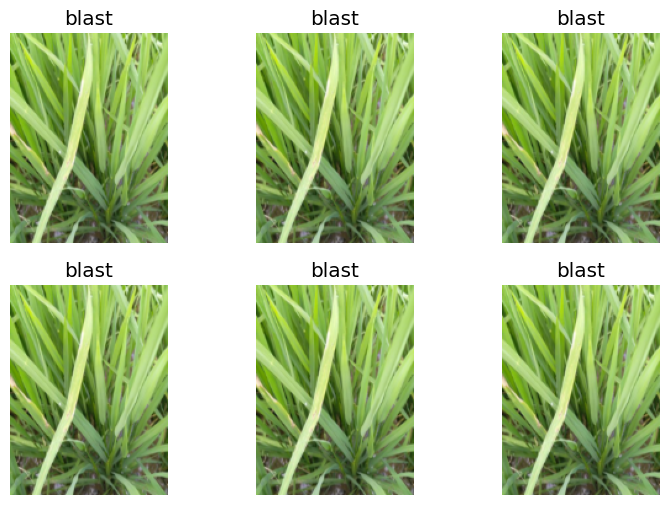

In [55]:
learn.dls.valid.show_batch(max_n = 6, unique = True)

In [58]:
tta_pred, tta_targs = learn.tta(dl = valid)

In [59]:
error_rate(tta_pred, tta_targs)

TensorBase(0.5887)

In [60]:
path

Path('/kaggle/input/paddy-disease-classification')

In [61]:
train_path = Path(path/'train_images')

In [62]:
learn = train('resnet26d', Resize(480, method = 'squish'), aug_transforms(size = 128, min_scale = 0.75), epochs = 12)

epoch,train_loss,valid_loss,error_rate,time
0,3.186986,2.288088,0.757328,02:15


epoch,train_loss,valid_loss,error_rate,time
0,2.689872,2.205425,0.741470,02:14
1,2.577564,2.093533,0.724171,02:15
2,2.341993,1.970235,0.681403,02:15
3,2.158340,1.881284,0.643441,02:15
4,2.057782,1.832759,0.609322,02:17
5,1.971284,1.785846,0.591543,02:26
6,1.947382,1.762648,0.576646,02:15
7,1.906250,1.738865,0.566074,02:15
8,1.890085,1.730588,0.570399,02:16
9,1.874012,1.723393,0.562710,02:15


In [64]:
preds, targs = learn.get_preds(dl = learn.dls.valid)

In [65]:
error_rate(preds, targs)

TensorBase(0.5622)

In [66]:
tta_preds, tta_targs = learn.tta(dl = learn.dls.valid)

In [67]:
error_rate(tta_preds, tta_targs)

TensorBase(0.5252)

In [74]:
list(path.glob('*'))

[Path('/kaggle/input/paddy-disease-classification/sample_submission.csv'),
 Path('/kaggle/input/paddy-disease-classification/train_images'),
 Path('/kaggle/input/paddy-disease-classification/train.csv'),
 Path('/kaggle/input/paddy-disease-classification/test_images')]

In [101]:
test_df = pd.read_csv(path / 'sample_submission.csv')

In [70]:
test_path = path / 'test_images'
test_path

Path('/kaggle/input/paddy-disease-classification/test_images')

In [77]:
test_images = get_image_files(test_path).sorted()
test_images

(#3469) [Path('/kaggle/input/paddy-disease-classification/test_images/200001.jpg'),Path('/kaggle/input/paddy-disease-classification/test_images/200002.jpg'),Path('/kaggle/input/paddy-disease-classification/test_images/200003.jpg'),Path('/kaggle/input/paddy-disease-classification/test_images/200004.jpg'),Path('/kaggle/input/paddy-disease-classification/test_images/200005.jpg'),Path('/kaggle/input/paddy-disease-classification/test_images/200006.jpg'),Path('/kaggle/input/paddy-disease-classification/test_images/200007.jpg'),Path('/kaggle/input/paddy-disease-classification/test_images/200008.jpg'),Path('/kaggle/input/paddy-disease-classification/test_images/200009.jpg'),Path('/kaggle/input/paddy-disease-classification/test_images/200010.jpg')...]

In [85]:
test_dl = learn.dls.test_dl(test_images)

In [87]:
list(test_dl)[0]

(TensorImage([[[[ 7.9142e-01,  1.3943e+00,  8.9304e-01,  ...,  1.1622e+00,  1.4523e+00,  1.2296e+00],
                [ 7.6929e-01,  1.2387e+00,  8.2973e-01,  ...,  9.9114e-01,  8.2876e-01,  8.1152e-01],
                [ 5.1142e-01,  1.2865e+00,  7.2619e-01,  ...,  1.0451e+00,  7.4496e-01,  2.6440e-01],
                ...,
                [ 4.2800e-01,  1.3493e-01, -1.8458e-01,  ..., -9.0047e-01, -9.0789e-01, -8.3015e-01],
                [-7.2865e-01,  1.4315e-01,  5.4888e-01,  ..., -9.0865e-01, -7.6572e-01, -8.8092e-01],
                [-7.4570e-01, -7.3514e-01, -1.0765e-01,  ..., -8.2007e-01, -9.8442e-01, -4.7694e-01]],
 
               [[ 1.3191e+00,  1.8981e+00,  1.5641e+00,  ...,  1.6877e+00,  1.9300e+00,  1.5724e+00],
                [ 1.2929e+00,  1.7659e+00,  1.4609e+00,  ...,  1.6103e+00,  1.4235e+00,  1.3623e+00],
                [ 1.0644e+00,  1.7970e+00,  1.2700e+00,  ...,  1.6861e+00,  1.4337e+00,  1.0667e+00],
                ...,
                [ 1.1512e+00,  9.0003

In [89]:
learn.get_preds(dl = test_dl)

(tensor([[0.0465, 0.0185, 0.0095,  ..., 0.1090, 0.1788, 0.1801],
         [0.0250, 0.0163, 0.0205,  ..., 0.1421, 0.5005, 0.0337],
         [0.0258, 0.0217, 0.0085,  ..., 0.5840, 0.1313, 0.0138],
         ...,
         [0.0254, 0.0342, 0.0156,  ..., 0.0775, 0.6054, 0.0391],
         [0.0408, 0.0128, 0.0145,  ..., 0.3741, 0.1412, 0.0382],
         [0.0547, 0.0199, 0.0354,  ..., 0.1446, 0.1490, 0.0822]]),
 None)

In [110]:
test_pred = learn.tta(dl = test_dl)

In [111]:
len(test_pred)

2

In [124]:
test = np.array([np.argmax(i) for i in test_pred[0]])
test

array([8, 8, 7, ..., 8, 7, 5])

In [121]:
tests_pred = test_pred[0].argmax(dim = 1)
tests_pred

tensor([8, 8, 7,  ..., 8, 7, 5])

In [117]:
vocab = np.array(learn.dls.vocab)
vocab

array(['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro'], dtype='<U24')

In [103]:
test_df.columns

Index(['image_id', 'label'], dtype='object')

In [119]:
test_df['label'] = pd.Series(vocab[tests_pred])

In [125]:
mapping = dict(enumerate(learn.dls.vocab))
mapping

{0: 'bacterial_leaf_blight',
 1: 'bacterial_leaf_streak',
 2: 'bacterial_panicle_blight',
 3: 'blast',
 4: 'brown_spot',
 5: 'dead_heart',
 6: 'downy_mildew',
 7: 'hispa',
 8: 'normal',
 9: 'tungro'}

In [127]:
test_df2 = test_df
test_df2['label'] = pd.Series(test).map(mapping)
test_df2

,image_id,label
0,200001.jpg,normal
1,200002.jpg,normal
2,200003.jpg,hispa
3,200004.jpg,blast
4,200005.jpg,blast
...,...,...
3464,203465.jpg,dead_heart
3465,203466.jpg,normal
3466,203467.jpg,normal
3467,203468.jpg,hispa


In [120]:
test_df

,image_id,label
0,200001.jpg,normal
1,200002.jpg,normal
2,200003.jpg,hispa
3,200004.jpg,blast
4,200005.jpg,blast
...,...,...
3464,203465.jpg,dead_heart
3465,203466.jpg,normal
3466,203467.jpg,normal
3467,203468.jpg,hispa


In [108]:
!pwd

/kaggle/working


In [109]:
test_df.to_csv('./submission.csv')

In [1]:
!pip install fastbook
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 11.4 MB/s eta 0:00:00a 0:00:01


In [2]:
from fastai.vision.all import *

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
path = Path('/kaggle/input/paddy-disease-classification')

In [4]:
path

Path('/kaggle/input/paddy-disease-classification')

In [6]:
pd.read_csv(path/'train.csv')['label'].value_counts()

normal                      1764
blast                       1738
hispa                       1594
dead_heart                  1442
tungro                      1088
brown_spot                   965
downy_mildew                 620
bacterial_leaf_blight        479
bacterial_leaf_streak        380
bacterial_panicle_blight     337
Name: label, dtype: int64

In [7]:
train_path = path / 'train_images/bacterial_panicle_blight'
train_path

Path('/kaggle/input/paddy-disease-classification/train_images/bacterial_panicle_blight')

In [9]:
len(list(train_path.glob('*')))

337

In [11]:
test_files = get_image_files(path/'test_images').sorted()
test_files

(#3469) [Path('/kaggle/input/paddy-disease-classification/test_images/200001.jpg'),Path('/kaggle/input/paddy-disease-classification/test_images/200002.jpg'),Path('/kaggle/input/paddy-disease-classification/test_images/200003.jpg'),Path('/kaggle/input/paddy-disease-classification/test_images/200004.jpg'),Path('/kaggle/input/paddy-disease-classification/test_images/200005.jpg'),Path('/kaggle/input/paddy-disease-classification/test_images/200006.jpg'),Path('/kaggle/input/paddy-disease-classification/test_images/200007.jpg'),Path('/kaggle/input/paddy-disease-classification/test_images/200008.jpg'),Path('/kaggle/input/paddy-disease-classification/test_images/200009.jpg'),Path('/kaggle/input/paddy-disease-classification/test_images/200010.jpg')...]

In [12]:
def train(arch, size, item = Resize(480, method = 'squish'), accum = 1, finetune = True, epochs = 12):
    dls = ImageDataLoaders.from_folder(
        train_path, 
        valid_pct = 0.2,
        item_tfms = item,
        batch_tfms = aug_transforms(size = size, min_scale = 0.75),
        bs = 64 // accum
    )
    
    cbs = GradientAccumulation(64) if accum else []
    learn = vision_learner(dls, arch, cbs = cbs, metrics = error_rate).to_fp16()
    if(finetune):
        learn.fine_tune(epochs, 0.01)
        return learn.tta(learn.dls.test_dl(test_files))
    else:
        learn.unfreeze()
        learn.fit_one_cycle(epochs, 0.01)

In [14]:
import timm

In [28]:
timm.list_models('convnext*', pretrained = True)

['convnext_atto.d2_in1k',
 'convnext_atto_ols.a2_in1k',
 'convnext_base.clip_laion2b',
 'convnext_base.clip_laion2b_augreg',
 'convnext_base.clip_laion2b_augreg_ft_in1k',
 'convnext_base.clip_laion2b_augreg_ft_in12k',
 'convnext_base.clip_laion2b_augreg_ft_in12k_in1k',
 'convnext_base.clip_laion2b_augreg_ft_in12k_in1k_384',
 'convnext_base.clip_laiona',
 'convnext_base.clip_laiona_320',
 'convnext_base.clip_laiona_augreg_320',
 'convnext_base.clip_laiona_augreg_ft_in1k_384',
 'convnext_base.fb_in1k',
 'convnext_base.fb_in22k',
 'convnext_base.fb_in22k_ft_in1k',
 'convnext_base.fb_in22k_ft_in1k_384',
 'convnext_femto.d1_in1k',
 'convnext_femto_ols.d1_in1k',
 'convnext_large.fb_in1k',
 'convnext_large.fb_in22k',
 'convnext_large.fb_in22k_ft_in1k',
 'convnext_large.fb_in22k_ft_in1k_384',
 'convnext_large_mlp.clip_laion2b_augreg',
 'convnext_large_mlp.clip_laion2b_augreg_ft_in1k',
 'convnext_large_mlp.clip_laion2b_augreg_ft_in1k_384',
 'convnext_large_mlp.clip_laion2b_augreg_ft_in12k_384',

In [29]:
train('convnext_tiny.in12k', 128, finetune = False, epochs = 1)

epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:07


In [30]:
import gc

In [31]:
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()

In [32]:
report_gpu()

GPU:0
process       3655 uses     5301.000 MB GPU memory


In [33]:
train('convnext_tiny.in12k', 128, finetune = False, epochs = 1, accum = 2)
report_gpu()

epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:09


GPU:0
process       3655 uses     2239.000 MB GPU memory


In [34]:
report_gpu()

GPU:0
process       3655 uses     1167.000 MB GPU memory


In [35]:
train('convnext_tiny.in12k', 128, finetune = False, epochs = 1, accum = 4)

epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:12


In [36]:
report_gpu()

GPU:0
process       3655 uses     1927.000 MB GPU memory


In [37]:
train('convnext_large.fb_in22k', 128, finetune = False, epochs = 1, accum = 1)
report_gpu()

epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:18


GPU:0
process       3655 uses     8817.000 MB GPU memory


In [42]:
report_gpu()

GPU:0
process       3655 uses    16267.000 MB GPU memory


In [43]:
report_gpu()

GPU:0
process       3655 uses     4021.000 MB GPU memory


In [44]:
timm.list_models('vit*', pretrained = True)

['vit_base_patch8_224.augreg2_in21k_ft_in1k',
 'vit_base_patch8_224.augreg_in21k',
 'vit_base_patch8_224.augreg_in21k_ft_in1k',
 'vit_base_patch8_224.dino',
 'vit_base_patch14_dinov2.lvd142m',
 'vit_base_patch16_224.augreg2_in21k_ft_in1k',
 'vit_base_patch16_224.augreg_in1k',
 'vit_base_patch16_224.augreg_in21k',
 'vit_base_patch16_224.augreg_in21k_ft_in1k',
 'vit_base_patch16_224.dino',
 'vit_base_patch16_224.mae',
 'vit_base_patch16_224.orig_in21k_ft_in1k',
 'vit_base_patch16_224.sam_in1k',
 'vit_base_patch16_224_miil.in21k',
 'vit_base_patch16_224_miil.in21k_ft_in1k',
 'vit_base_patch16_384.augreg_in1k',
 'vit_base_patch16_384.augreg_in21k_ft_in1k',
 'vit_base_patch16_384.orig_in21k_ft_in1k',
 'vit_base_patch16_clip_224.laion2b',
 'vit_base_patch16_clip_224.laion2b_ft_in1k',
 'vit_base_patch16_clip_224.laion2b_ft_in12k',
 'vit_base_patch16_clip_224.laion2b_ft_in12k_in1k',
 'vit_base_patch16_clip_224.openai',
 'vit_base_patch16_clip_224.openai_ft_in1k',
 'vit_base_patch16_clip_224.op

In [ ]:
train('vit_large_patch16_224', 224, epochs = 1, finetune = False)

In [2]:
!pip install -Uqq fastbook

In [3]:
from fastbook import *

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
train_path = Path('/kaggle/input/paddy-disease-classification/train_images')

In [6]:
res = (640, 480)

In [7]:
models = {
    'convnext_large_in22k': {
        (Resize(res), (320,224)),
    }, 'vit_large_patch16_224': {
        (Resize(480, method='squish'), 224),
        (Resize(res), 224),
    }, 'swinv2_large_window12_192_22k': {
        (Resize(480, method='squish'), 192),
        (Resize(res), 192),
    }, 'swin_large_patch4_window7_224': {
        (Resize(res), 224),
    }
}

In [14]:
def train(arch, size, item = Resize(480, method = 'squish'), accum = 1, finetune = True, epochs = 12):
    dls = ImageDataLoaders.from_folder(
        train_path, 
        valid_pct = 0.2,
        item_tfms = item,
        batch_tfms = aug_transforms(size = size, min_scale = 0.75),
        bs = 64 // accum
    )
    
    cbs = GradientAccumulation(64) if accum else []
    learn = vision_learner(dls, arch, cbs = cbs, metrics = error_rate).to_fp16()
    if(finetune):
        learn.fine_tune(epochs, 0.01)
        return learn.tta(learn.dls.test_dl(test_files))
    else:
        learn.unfreeze()
        learn.fit_one_cycle(epochs, 0.01)

In [15]:
import gc

In [16]:
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()

In [19]:
# tta_res = []

# for arch, details in models.items():
#     for item, size in details:
#         print('----', arch)
#         print(size)
#         print(item.name)
#         tta_res.append(train(arch, size, item, accum = 2, epochs = 1))
#         gc.collect()
#         torch.cuda.empty_cache()

In [25]:
first(zip([1, 2, 3, 4, 5], [6, 7, 8, 9]))

(1, 6)

In [26]:
path = Path('/kaggle/input/paddy-disease-classification')

In [27]:
train_path = path / 'train_images'

In [30]:
df = pd.read_csv(path/'train.csv', index_col = 'image_id')
df.head()

,label,variety,age
image_id,,,
100330.jpg,bacterial_leaf_blight,ADT45,45
100365.jpg,bacterial_leaf_blight,ADT45,45
100382.jpg,bacterial_leaf_blight,ADT45,45
100632.jpg,bacterial_leaf_blight,ADT45,45
101918.jpg,bacterial_leaf_blight,ADT45,45


In [32]:
df.loc['100330.jpg', 'variety']

'ADT45'

In [33]:
def get_variety(p): return df.loc[p.name, 'variety']

In [36]:
dls = DataBlock(
    blocks = (ImageBlock, CategoryBlock, CategoryBlock),
    n_inp = 1,
    item_tfms = Resize(192, method = 'squish'),
    batch_tfms = aug_transforms(size = 128, min_scale = 0.75),
    get_items = get_image_files,
    get_y = [parent_label, get_variety],
    splitter = RandomSplitter(0.2, seed = 42)
).dataloaders(train_path)

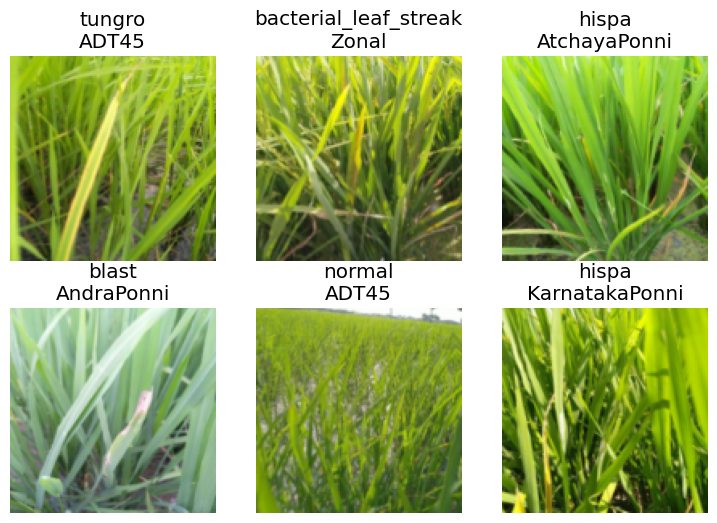

In [38]:
dls.show_batch(max_n = 6)

In [76]:
def disease_loss(inp, disease, variety): return F.cross_entropy(inp[:, :10], disease)
def variety_loss(inp, disease, variety): return F.cross_entropy(inp[:, 10:], variety)

def combine_loss(inp, disease, variety): return disease_loss(inp, disease, variety) + variety_loss(inp, disease, variety)

In [77]:
def disease_err(inp, disease, variety): return error_rate(inp[:, :10], disease)
def variety_err(inp, disease, variety): return error_rate(inp[:, 10:], variety)

err_metrics = (disease_err, variety_err)

In [78]:
all_metrics = err_metrics + (disease_loss, variety_loss)
all_metrics

(<function __main__.disease_err(inp, disease, variety)>,
 <function __main__.variety_err(inp, disease, variety)>,
 <function __main__.disease_loss(inp, disease, variety)>,
 <function __main__.variety_loss(inp, disease, variety)>)

In [79]:
learn = vision_learner(dls, 'convnext_tiny', n_out = 20, metrics = all_metrics, loss_func = combine_loss).to_fp16()

In [80]:
learn.fine_tune(5, 0.01)

epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,4.932173,3.208351,0.682364,0.318597,2.029378,1.178973,02:30


epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,3.810577,3.013755,0.654493,0.311389,1.893471,1.120285,02:38
1,3.432546,2.732374,0.595867,0.309947,1.725174,1.007199,02:39
2,3.080389,2.602073,0.569438,0.301297,1.638195,0.963877,02:41
3,2.977352,2.563993,0.553580,0.300817,1.612984,0.951009,02:42
4,2.906095,2.564377,0.557905,0.298414,1.616443,0.947934,02:38


In [91]:
test_files = get_image_files('/kaggle/input/paddy-disease-classification/test_images')

In [92]:
pred1 = learn.get_preds(dl = dls.test_dl(test_files))
pred1

(tensor([[-0.3037, -0.7012, -1.8350,  ..., -2.1289, -1.1543,  0.8208],
         [-0.0771, -0.7183, -0.3525,  ..., -1.1270, -1.8330,  0.2869],
         [ 0.0251,  0.0973,  0.1592,  ..., -1.4639, -1.2861, -0.2285],
         ...,
         [-1.6006, -1.1025,  1.6641,  ..., -0.9248, -1.7920,  0.4678],
         [ 0.4438, -0.0688, -1.4805,  ..., -2.3027, -1.2432,  0.0565],
         [ 0.3521,  0.0038, -1.2402,  ..., -2.3379, -1.2812,  0.4541]]),
 None)

In [93]:
pred2 = learn.tta(dl = dls.test_dl(test_files))
pred2

(tensor([[-0.1485, -0.6840, -1.7304,  ..., -2.0820, -1.3531,  0.7142],
         [-0.5344, -0.8935, -0.9030,  ..., -1.6442, -1.5150,  0.0441],
         [-0.3934,  0.1001, -0.0706,  ..., -1.0870, -1.1177,  0.6070],
         ...,
         [-1.4561, -0.9606,  1.8265,  ..., -1.0644, -1.9189,  0.1669],
         [-0.1888, -0.4546, -1.5219,  ..., -2.2368, -1.4574,  0.1049],
         [ 0.2541,  0.0846, -1.2844,  ..., -2.4243, -1.7377,  0.4251]]),
 None)